# Phillies Quantitative Analyst Take-Home
### Author: Ryan Williams
### Date: 05/13/2025

**Language**: Julia 1.11+

This notebook addresses Question 11 of the assessment, where we are tasked with predicting each pitcher's 2024 strikeout percentage (K%) using their prior performance data.

We use a hierarchical Bayesian model implemented via `Turing.jl` to estimate future K% while accounting for player-level effects and uncertainty.


## Analysis Setup

In [ ]:
# Setup Julia environment for the k_model package
using Pkg
Pkg.activate("k_model_env")
Pkg.add([
    "CSV",
    "DataFrames",
    "StatsPlots",
    "Turing",
    "Random",
    "Distributions",
    "StatsBase",
    "CategoricalArrays",
    "Measures",
    "MCMCChains",
    "MLJ",
    "MLJLinearModels",
    "MLJBase",
    "StatisticalMeasures",
    "DecisionTree",
    "MLJDecisionTreeInterface"
])
Pkg.precompile()

In [ ]:
# Load libraries
using CSV, DataFrames
using StatsPlots
using Turing
using Random, Distributions
using StatsBase
using Measures
# using CategoricalArrays
using LinearAlgebra
using MCMCChains
using MLJ
using MLJBase
# using MLJLinearModels
using DecisionTree
using MLJDecisionTreeInterface
Random.seed!(42)

### Load and inspect data
We begin by loading `k.csv`, which contains:
- Player identifiers (MLBAMID, FanGraphs ID)
- Age and season
- Total Batters Faced (TBF) and Strikeout Percentage (K%)

In [6]:
df = CSV.read("k.csv", DataFrame)
first(df, 5) |> println
describe(df) |> println

5×8 DataFrame
 Row │ MLBAMID  PlayerId  Name            Team     Age    Season  TBF    K%       
     │ Int64    Int64     String31        String7  Int64  Int64   Int64  Float64  
─────┼────────────────────────────────────────────────────────────────────────────
   1 │  695243     31757  Mason Miller    OAK         25    2024    249  0.417671
   2 │  621242     14710  Edwin Díaz      NYM         30    2024    216  0.388889
   3 │  518585      7048  Fernando Cruz   CIN         34    2024    288  0.378472
   4 │  623352     14212  Josh Hader      HOU         30    2024    278  0.377698
   5 │  663574     19926  Tony Santillan  CIN         27    2024    122  0.377049
8×7 DataFrame
 Row │ variable  mean       min          median    max             nmissing  eltype   
     │ Symbol    Union…     Any          Union…    Any             Int64     DataType 
─────┼────────────────────────────────────────────────────────────────────────────────
   1 │ MLBAMID   6.20025e5  425794       641712.0  8

### Preprocess Data
- We sort by season and player
- We compute lagged K% and TBF
- We exclude rows with missing historical data (e.g., rookies)

In [ ]:
# Rename columns for clarity
rename!(df, Symbol("K%") => :K)

# Sort the DataFrame to ensure proper ordering within each player group
sort!(df, [:MLBAMID, :Season])

# Initialize new columns with missing values
df[!, :K_prev] = Vector{Union{Missing, Float64}}(missing, nrow(df))
df[!, :TBF_prev] = Vector{Union{Missing, Int64}}(missing, nrow(df))

# Fill previous season's K% and TBF for each pitcher
for g in groupby(df, :MLBAMID)
    global_indices = findall(x -> x in g.MLBAMID, df.MLBAMID)
    for i in 2:nrow(g)
        curr_idx = global_indices[i]
        prev_idx = global_indices[i - 1]

        df[!, :K_prev][curr_idx] = df[!, :K][prev_idx]
        df[!, :TBF_prev][curr_idx] = df[!, :TBF][prev_idx]
    end
end

# Drop rows that don’t have lagged values (e.g. rookies or first-year records)
df_model = dropmissing(df, [:K_prev, :TBF_prev])

# Add derived features
df_model[!, :ΔK] = df_model.K .- df_model.K_prev         # Change in K% from last season
df_model[!, :is_relief] = df_model.TBF .< 200            # Likely a reliever if under 200 TBF

## Model Definition
We model K% as a function of prior stats, with player-level intercepts.

### Define Model Inputs

In [ ]:
unique_players = unique(df_model.MLBAMID)
player_lookup = Dict(pid => i for (i, pid) in enumerate(unique_players))
player_index = [player_lookup[pid] for pid in df_model.MLBAMID]

In [ ]:
# Select feature matrix and target vector
X = DataFrames.select(df_model, [:K_prev, :TBF_prev, :Age, :ΔK, :is_relief])
y = df_model.K
y_vec = y

### Split into training (before 2024) and test (2024 season) 

In [17]:
df_train = filter(row -> row.Season < 2024, df_model)
df_test = filter(row -> row.Season == 2024, df_model)

X_train = DataFrames.select(df_train, [:K_prev, :TBF_prev, :Age, :ΔK, :is_relief])
y_train = df_train.K

X_test = DataFrames.select(df_test, [:K_prev, :TBF_prev, :Age, :ΔK, :is_relief])
y_test = df_test.K

@assert isempty(intersect(
    zip(df_train.MLBAMID, df_train.Season),
    zip(df_test.MLBAMID, df_test.Season)
)) "Train/test data leakage detected!"

### Train Ridge Regression Model

In [ ]:
RidgeRegressor = @load RidgeRegressor pkg=MLJLinearModels
ridge_model = RidgeRegressor(lambda=0.1)
ridge_mach = machine(ridge_model, X_train, y_train)
MLJBase.fit!(ridge_mach)

### Train Random Forest model

In [ ]:
# Fit Random Forest Regressor with MLJ
RandomForest = @load RandomForestRegressor pkg=DecisionTree

rf_model = RandomForest(n_trees=100)
rf_mach = machine(rf_model, X, y)
MLJBase.fit!(rf_mach)

### Make Predictions

In [ ]:
# Ridge regression predictions
y_pred_ridge = MLJ.predict(ridge_mach, X_test) |> MLJ.unwrap

# Random Forest predictions
y_pred_rf = MLJ.predict(rf_mach, X_test) |> MLJ.unwrap

### Performance Evaluation

In [54]:
# Sanity check: Ensure no overlap in player-season rows (by MLBAMID and Season)
@assert isempty(intersect(
    zip(df_train.MLBAMID, df_train.Season),
    zip(df_test.MLBAMID, df_test.Season)
)) "Train/test data leakage detected!"

In [37]:
# Ridge Regression evaluation
r2_ridge = rsq(y_pred_ridge, y_test)
rmse_ridge = sqrt(mean((y_test .- y_pred_ridge).^2))

println("\nR² Score (Ridge Regression): ", round(r2_ridge, digits=4))
println("RMSE (Ridge Regression): ", round(rmse_ridge, digits=4))

# Random Forest evaluation
r2_rf = rsq(y_pred_rf, y_test)
rmse_rf = sqrt(mean((y_test .- y_pred_rf).^2))

println("\nR² Score (Random Forest): ", round(r2_rf, digits=4))
println("RMSE (Random Forest): ", round(rmse_rf, digits=4))


R² Score (Ridge Regression): 0.032
RMSE (Ridge Regression): 0.0516

R² Score (Random Forest): 0.9816
RMSE (Random Forest): 0.0071


In [ ]:
# Store predictions in DataFrame
df_model.K_pred = y_pred

### Result Visualizations

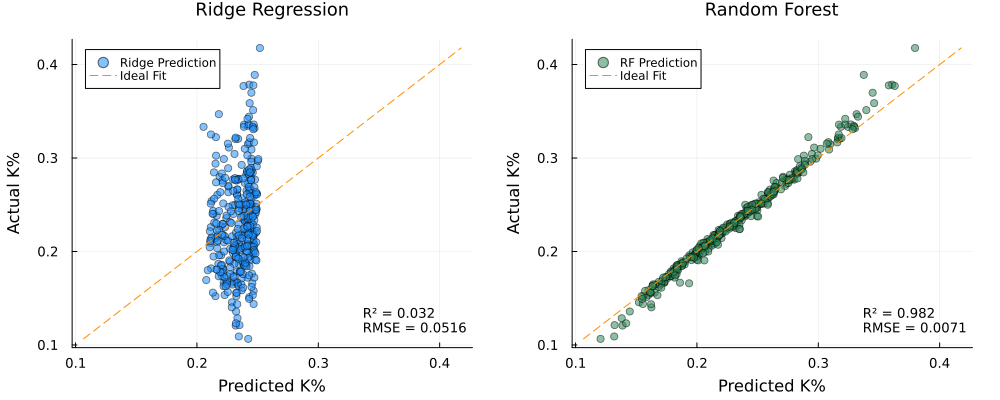

In [117]:
ridge_metrics = "R² = $(round(r2_ridge, digits=3))\nRMSE = $(round(rmse_ridge, digits=4))"
rf_metrics = "R² = $(round(r2_rf, digits=3))\nRMSE = $(round(rmse_rf, digits=4))"

# Side-by-side layout
plt = plot(layout = (1, 2), size = (1000, 400), margin = 5mm, titlefontsize = 12, tickfontsize = 9)

# Ridge Regression plot
scatter!(
    plt,
    y_pred_ridge, y_test,
    subplot = 1,
    color = :dodgerblue,
    label = "Ridge Prediction",
    xlabel = "Predicted K%",
    ylabel = "Actual K%",
    title = "Ridge Regression",
    markersize = 4,
    legend = :topleft,
    alpha = 0.55,
)

plot!(
    plt,
    [minimum(y_test), maximum(y_test)],
    [minimum(y_test), maximum(y_test)],
    linestyle = :dash,
    color = :darkorange,
    label = "Ideal Fit",
    subplot = 1,
)

# Ridge metrics text
# Annotate metrics
annotate!(
    plt,
    subplot = 1,
    maximum(y_test) - 0.08,
    minimum(y_test) + 0.02,
    text(ridge_metrics, :left, 9, :black),
)

# Random Forest plot
scatter!(
    plt,
    y_pred_rf, y_test,
    subplot = 2,
    color = :seagreen,
    label = "RF Prediction",
    xlabel = "Predicted K%",
    ylabel = "Actual K%",
    title = "Random Forest",
    markersize = 4,
    legend = :topleft,
    alpha = 0.55,
)

plot!(
    plt,
    [minimum(y_test), maximum(y_test)],
    [minimum(y_test), maximum(y_test)],
    linestyle = :dash,
    color = :darkorange,
    label = "Ideal Fit",
    subplot = 2,
)

# RF metrics text
annotate!(
    plt,
    subplot = 2,
    maximum(y_test) - 0.08,
    minimum(y_test) + 0.02,
    text(rf_metrics, :left, 9, :black),
)

# Save the figure
savefig("figures/model_comparison.png")

plt  # Show in notebook

### Residual Analysis by Group

In [ ]:
# Compute residuals for both models
df_test.resid_ridge = y_test .- y_pred_ridge
df_test.resid_rf = y_test .- y_pred_rf

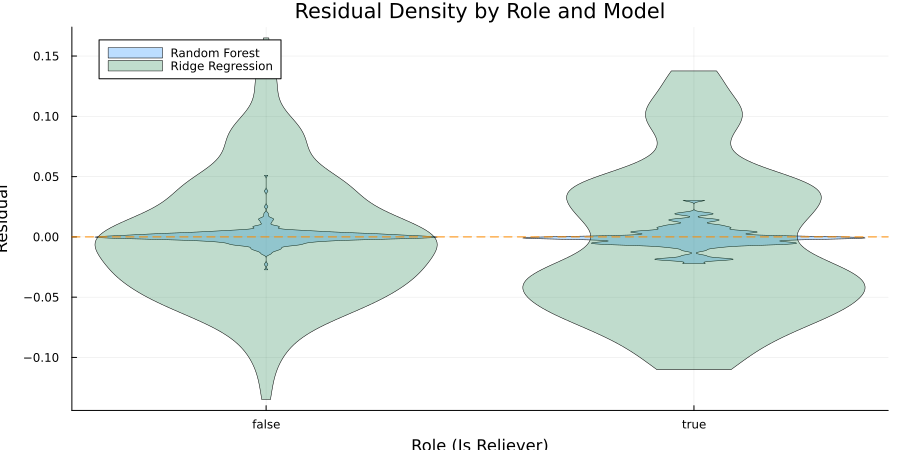

In [116]:
# Convert boolean to string for display
df_test.role_str = string.(df_test.is_relief)

# Stack residuals and labels
ridge_roles = repeat(df_test.role_str, 1)
rf_roles = repeat(df_test.role_str, 1)

ridge_vals = df_test.resid_ridge
rf_vals = df_test.resid_rf

residuals = vcat(ridge_vals, rf_vals)
roles = vcat(ridge_roles, rf_roles)
models = vcat(fill("Ridge", length(ridge_vals)), fill("RF", length(rf_vals)))

# Combine into a DataFrame
resid_df = DataFrame(
    residual = residuals,
    role = roles,
    model = models
)

# Plot
@df resid_df violin(
    :role,
    :residual,
    group = :model,
    legend = :topleft,
    label = ["Random Forest" "Ridge Regression"],
    xlabel = "Role (Is Reliever)",
    ylabel = "Residual",
    title = "Residual Density by Role and Model",
    fillalpha = 0.3,
    linewidth = 0.5,
    color = [:dodgerblue :seagreen],
    size = (900, 450)
)
hline!([0], linestyle=:dash, color=:darkorange, label="")

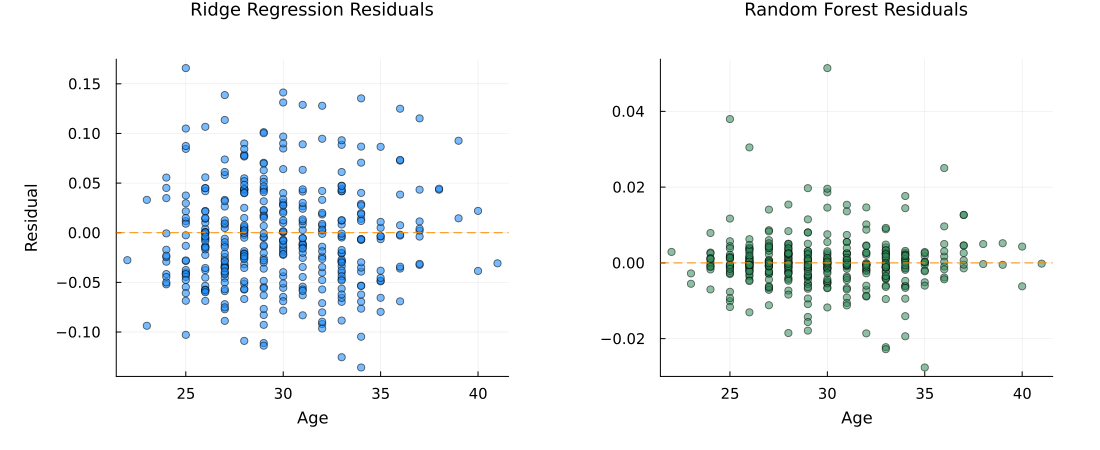

In [ ]:
plt = plot(
    layout = (1, 2),
    size = (1100, 450), 
    titlefontsize = 12,
    tickfontsize = 10,
    margin = 10mm,     
)

# Ridge Regression Residuals
scatter!(
    plt,
    df_test.Age,
    df_test.resid_ridge,
    xlabel = "Age",
    ylabel = "Residual",
    title = "Ridge Regression Residuals",
    color = :dodgerblue,
    alpha = 0.6,
    legend = false,
    markersize = 4,
    subplot = 1
)

hline!(plt, [0], linestyle = :dash, color = :darkorange, subplot = 1)

# Random Forest Residuals
scatter!(
    plt,
    df_test.Age,
    df_test.resid_rf,
    xlabel = "Age",
    ylabel = "",
    title = "Random Forest Residuals",
    color = :seagreen,
    alpha = 0.55,
    legend = false,
    markersize = 4,
    subplot = 2
)

hline!(plt, [0], linestyle = :dash, color = :darkorange, subplot = 2)

display(plt)

### Feature Importance Comparison

In [ ]:
# Compute feature importances using MLJ's built-in helper
fi = MLJ.feature_importances(mach_2024)

# Extract keys and values separately
feature_names = collect(keys(fi))
importance_vals = collect(values(fi))

# Wrap in DataFrame
importance_df = DataFrame(feature=feature_names, importance=importance_vals)

# Sort and display
sort!(importance_df, :importance, rev=true)
display(importance_df)

In [ ]:
# Split the Pair vector
feature_labels = string.(first.(fi))
importance_scores = last.(fi)

bar(
    feature_labels,
    importance_scores,
    legend=false,
    xlabel="Features",
    ylabel="Importance Score",
    title="Feature Importances (Random Forest)",
    bar_width=0.7,
    size=(700, 400),
    xtickfont=font(10, rotation=45),
    color=:steelblue 
)